# Load libraries

In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Define functions

In [2]:
def jaccard_coef(y_true, y_pred):
    y_true_fl = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_fl = K.clip(K.batch_flatten(y_pred), 0., 1.)
    y_true_fl = K.cast(K.greater(y_true_fl, 0.5), 'float32')
    y_pred_fl = K.cast(K.greater(y_pred_fl, 0.5), 'float32')
    intersection = K.sum(y_true_fl * y_pred_fl, axis=1)
    union = K.sum(K.maximum(y_true_fl, y_pred_fl), axis=1)
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))

def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

def dice(y_true, y_pred):
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)

def dice_coef(y_true, y_pred):
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))

# Define models

In [3]:
def unet_down_one_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [4]:
def unet_max_pool(inputs):
    x = MaxPooling2D((2, 2), strides=(2, 2))(inputs)
    return x

In [5]:
def unet_up_one_block(up_input, down_input, num_filters):
    x = UpSampling2D((2,2))(up_input)
    x = concatenate([down_input, x], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [8]:
from keras.utils import plot_model  
plot_model(model, to_file='model-512.png', show_shapes=True, show_layer_names=True)  
from IPython.display import FileLink
FileLink('model-512.png')

/home/ubuntu/workspace/Fundus_UNET/model-512.png

# Training

In [9]:
input_size = 512
max_epochs = 50
threshold  = 0.5

train_batch_size = 14
val_batch_size   = 32

In [10]:
df_train = pd.read_csv('data2/data/train_masks.csv')

In [11]:
df_train.head()

,img,camera_short_name,camera_long_name,counter,suspect,eye,height,width,areaDisc,saturationPixels,saturationLevel,scale,g,b,factor,M,P,C
0,G-TPC0001-R.jpg,TPC,Topcon,1,1,R,1934,1956,70095,0,0,1081,1,1,0.9985,64.52,18,62.85
1,G-TPC0002-L.jpg,TPC,Topcon,2,1,L,1934,1956,58620,0,0,1081,1,1,0.9985,64.52,18,62.85
2,G-TPC0003-L.jpg,TPC,Topcon,3,1,L,1934,1956,58703,1100,0,1081,1,1,0.9985,64.52,18,62.85
3,G-TPC0004-R.jpg,TPC,Topcon,4,1,R,1934,1956,59826,0,0,1081,1,1,0.9985,64.52,18,62.85
4,G-TPC0005-L.jpg,TPC,Topcon,5,1,L,1934,1956,50247,0,0,1081,1,1,0.9985,64.52,18,62.85


In [12]:
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [13]:
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

In [14]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

In [15]:
def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


In [16]:
def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


In [17]:
all_imgs  = {}
all_masks = {}
for id in ids_train:
    img  = cv2.imread('data2/data/train/{}.jpg'.format(id))
    img  = cv2.resize(img, (input_size, input_size))
    mask = cv2.imread('data2/data/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (input_size, input_size))
    all_imgs[id]  = img
    all_masks[id] = mask

In [18]:
import random

In [19]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(list(ids_train_split), len(ids_train_split))
        for start in range(0, len(ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


In [20]:
def valid_generator(val_batch_size):
    while True:
        for start in range(0, len(ids_valid_split), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img  = all_imgs[id]
                mask = all_masks[id]
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch



In [21]:
callbacks = [EarlyStopping(monitor='val_dice_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_loss',
                             filepath='weights/best_weights_512.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/50
 - 53s - loss: 1.4995 - dice_loss: 0.0503 - jaccard_coef: 0.3031 - dice_coef: 0.4123 - val_loss: 1.4202 - val_dice_loss: 0.0611 - val_jaccard_coef: 0.4530 - val_dice_coef: 0.5973
Epoch 2/50
 - 39s - loss: 1.3526 - dice_loss: 0.0644 - jaccard_coef: 0.6165 - dice_coef: 0.7471 - val_loss: 1.3594 - val_dice_loss: 0.0673 - val_jaccard_coef: 0.5880 - val_dice_coef: 0.7263
Epoch 3/50
 - 39s - loss: 1.3181 - dice_loss: 0.0702 - jaccard_coef: 0.6810 - dice_coef: 0.7995 - val_loss: 1.3039 - val_dice_loss: 0.0727 - val_jaccard_coef: 0.7487 - val_dice_coef: 0.8479
Epoch 4/50
 - 39s - loss: 1.2932 - dice_loss: 0.0740 - jaccard_coef: 0.7183 - dice_coef: 0.8281 - val_loss: 1.2725 - val_dice_loss: 0.0760 - val_jaccard_coef: 0.7641 - val_dice_coef: 0.8609
Epoch 5/50
 - 39s - loss: 1.2697 - dice_loss: 0.0774 - jaccard_coef: 0.7412 - dice_coef: 0.8438 - val_loss: 1.2430 - val_dice_loss: 0.0816 - val_jaccard_coef: 0.7996 - val_dice_coef: 0.8833
Epoch 6/50
 - 39s - loss: 1.2447 - dice_loss: 0.08

Epoch 44/50
 - 39s - loss: 0.5435 - dice_loss: 0.4867 - jaccard_coef: 0.9006 - dice_coef: 0.9467 - val_loss: 0.5427 - val_dice_loss: 0.4879 - val_jaccard_coef: 0.8833 - val_dice_coef: 0.9368
Epoch 45/50
 - 39s - loss: 0.5227 - dice_loss: 0.5054 - jaccard_coef: 0.9013 - dice_coef: 0.9473 - val_loss: 0.5202 - val_dice_loss: 0.5078 - val_jaccard_coef: 0.8940 - val_dice_coef: 0.9433
Epoch 46/50
 - 39s - loss: 0.4996 - dice_loss: 0.5264 - jaccard_coef: 0.9024 - dice_coef: 0.9476 - val_loss: 0.4961 - val_dice_loss: 0.5296 - val_jaccard_coef: 0.8986 - val_dice_coef: 0.9454
Epoch 47/50
 - 39s - loss: 0.4766 - dice_loss: 0.5476 - jaccard_coef: 0.9050 - dice_coef: 0.9495 - val_loss: 0.4749 - val_dice_loss: 0.5492 - val_jaccard_coef: 0.8970 - val_dice_coef: 0.9451
Epoch 48/50
 - 39s - loss: 0.4548 - dice_loss: 0.5677 - jaccard_coef: 0.9073 - dice_coef: 0.9508 - val_loss: 0.4512 - val_dice_loss: 0.5705 - val_jaccard_coef: 0.9067 - val_dice_coef: 0.9504
Epoch 49/50
 - 39s - loss: 0.4320 - dice_loss

In [22]:
history.history

{'val_loss': [1.420223412513733,
  1.3594153960545858,
  1.3038797521591186,
  1.2724888213475545,
  1.2429692284266154,
  1.1930370966593424,
  1.191212805112203,
  1.1883797200520834,
  1.1770226097106933,
  1.157621308962504,
  1.13943568388621,
  1.1218807315826416,
  1.1044040822982788,
  1.0866346391042074,
  1.0711072731018065,
  1.0553948831558229,
  1.0405234464009603,
  1.0210798438390096,
  1.0081716362635296,
  0.9884490132331848,
  0.9763340409596761,
  0.9592757479349772,
  0.9427266112963358,
  0.9262411530812581,
  0.9098747070630392,
  0.8917964800198873,
  0.873935132821401,
  0.8603951199849447,
  0.8413142291704814,
  0.8253686404228211,
  0.8062320486704508,
  0.7916718546549479,
  0.771959110101064,
  0.7487789281209309,
  0.72979279200236,
  0.7125049750010173,
  0.6928011703491211,
  0.6727714077631632,
  0.6504952565828959,
  0.628719600836436,
  0.6075817656517029,
  0.5856305400530497,
  0.5639223376909892,
  0.542725666364034,
  0.5202107707659404,
  0.49608

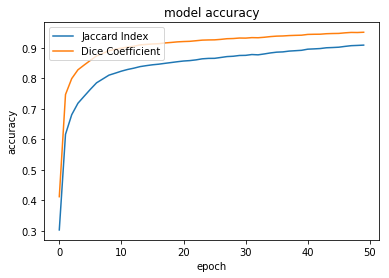

In [23]:
plt.plot(history.history['jaccard_coef'])
plt.plot(history.history['dice_coef'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Jaccard Index', 'Dice Coefficient'], loc='upper left')
plt.show()

In [24]:
model.load_weights('./weights/best_weights_512.hdf5')

In [25]:
 model.compile(optimizer=RMSprop(lr=0.00001),
                  loss=bce_dice_loss,
                  metrics=[dice_loss, jaccard_coef, dice_coef])

In [26]:
max_epochs = 10

In [27]:
callbacks = [EarlyStopping(monitor='val_dice_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_loss',
                             filepath='weights/best_weights_512_2.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))

Epoch 1/10
 - 45s - loss: 0.3907 - dice_loss: 0.6270 - jaccard_coef: 0.9167 - dice_coef: 0.9561 - val_loss: 0.4062 - val_dice_loss: 0.6132 - val_jaccard_coef: 0.9018 - val_dice_coef: 0.9477
Epoch 2/10
 - 39s - loss: 0.3887 - dice_loss: 0.6289 - jaccard_coef: 0.9181 - dice_coef: 0.9568 - val_loss: 0.3982 - val_dice_loss: 0.6204 - val_jaccard_coef: 0.9043 - val_dice_coef: 0.9491
Epoch 3/10
 - 39s - loss: 0.3852 - dice_loss: 0.6322 - jaccard_coef: 0.9197 - dice_coef: 0.9577 - val_loss: 0.3937 - val_dice_loss: 0.6245 - val_jaccard_coef: 0.9062 - val_dice_coef: 0.9502
Epoch 4/10
 - 39s - loss: 0.3828 - dice_loss: 0.6345 - jaccard_coef: 0.9207 - dice_coef: 0.9583 - val_loss: 0.3896 - val_dice_loss: 0.6286 - val_jaccard_coef: 0.9048 - val_dice_coef: 0.9494
Epoch 5/10
 - 39s - loss: 0.3810 - dice_loss: 0.6360 - jaccard_coef: 0.9214 - dice_coef: 0.9587 - val_loss: 0.3867 - val_dice_loss: 0.6312 - val_jaccard_coef: 0.9057 - val_dice_coef: 0.9499
Epoch 6/10
 - 39s - loss: 0.3792 - dice_loss: 0.63

In [28]:
history.history

{'val_loss': [0.4062019415696462,
  0.398215758005778,
  0.3937212876478831,
  0.38962904651959734,
  0.3867312713464101,
  0.38465957045555116,
  0.3823160151640574,
  0.3803468517462413,
  0.37833667238553365,
  0.3762530251344045],
 'val_dice_loss': [0.6131770396232605,
  0.6204473042488098,
  0.6244979294141134,
  0.6285634342829386,
  0.6312461988131205,
  0.6332133905092875,
  0.6353184000651042,
  0.6373090632756551,
  0.6391456421216329,
  0.6411411722501119],
 'val_jaccard_coef': [0.9018241373697916,
  0.9042847879727681,
  0.9061724440256754,
  0.9047887603441874,
  0.9056984718640645,
  0.9059363905588785,
  0.9068472584088644,
  0.9056708272298177,
  0.9066513824462891,
  0.9064091364542644],
 'val_dice_coef': [0.9477458071708679,
  0.9491315261522929,
  0.9502113278706869,
  0.9494016520182291,
  0.9499253996213277,
  0.9500565838813781,
  0.9505876914660136,
  0.9499006756146748,
  0.9504596130053202,
  0.9503130745887757],
 'loss': [0.3907952903707822,
  0.38869653875629

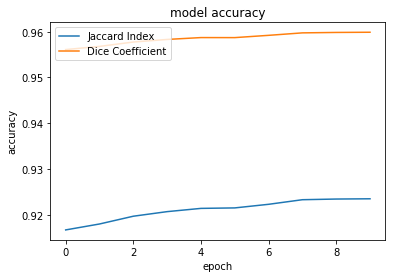

In [29]:
plt.plot(history.history['jaccard_coef'])
plt.plot(history.history['dice_coef'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Jaccard Index', 'Dice Coefficient'], loc='upper left')
plt.show()

# Predictions

In [30]:
from tqdm import tqdm

In [31]:
df_test = pd.read_csv('data2/data/test.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

In [32]:
names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))

In [33]:
model.load_weights(filepath='weights/best_weights_512_2.hdf5')

In [34]:
val_batch_size = 1

  0%|          | 0/265 [00:00<?, ?it/s]

Predicting on 265 samples with batch_size = 1...


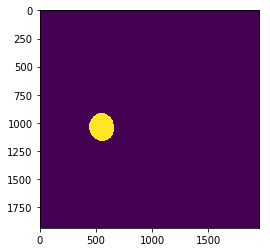

  0%|          | 1/265 [00:01<05:19,  1.21s/it]

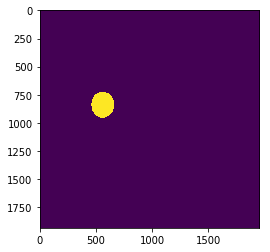

  1%|          | 2/265 [00:01<03:21,  1.31it/s]

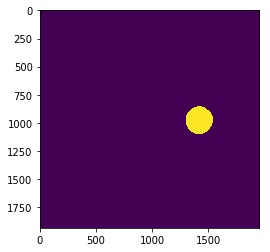

  1%|          | 3/265 [00:01<02:40,  1.64it/s]

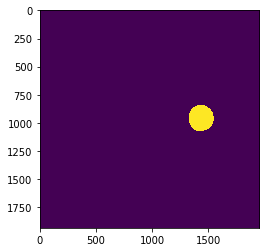

  2%|▏         | 4/265 [00:02<02:21,  1.84it/s]

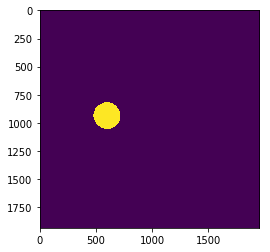

  2%|▏         | 5/265 [00:02<02:08,  2.02it/s]

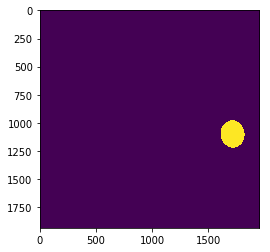

  2%|▏         | 6/265 [00:02<01:59,  2.17it/s]

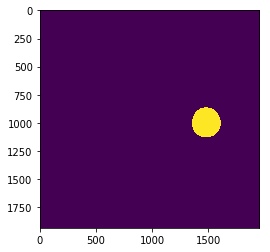

  3%|▎         | 7/265 [00:03<01:54,  2.26it/s]

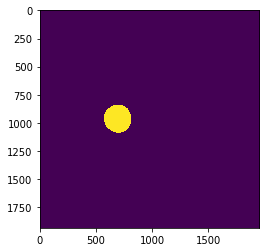

  3%|▎         | 8/265 [00:03<01:50,  2.32it/s]

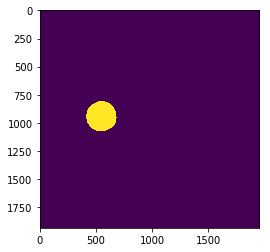

  3%|▎         | 9/265 [00:03<01:48,  2.37it/s]

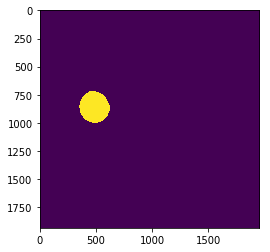

  4%|▍         | 10/265 [00:04<01:44,  2.44it/s]

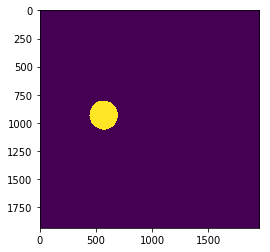

  4%|▍         | 11/265 [00:04<01:41,  2.50it/s]

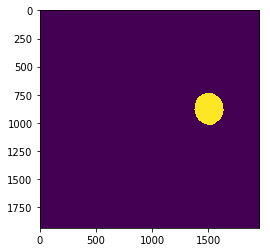

  5%|▍         | 12/265 [00:04<01:38,  2.56it/s]

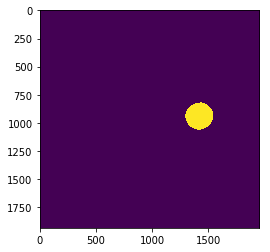

  5%|▍         | 13/265 [00:04<01:36,  2.61it/s]

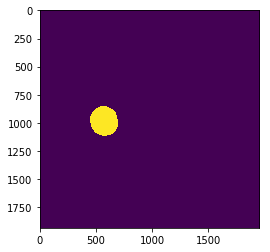

  5%|▌         | 14/265 [00:05<01:34,  2.65it/s]

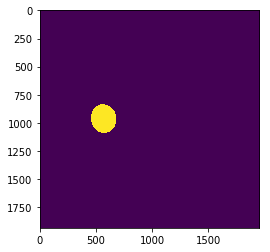

  6%|▌         | 15/265 [00:05<01:32,  2.69it/s]

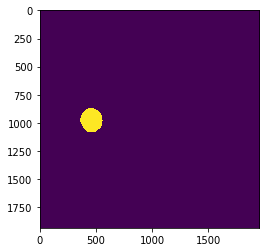

  6%|▌         | 16/265 [00:05<01:31,  2.72it/s]

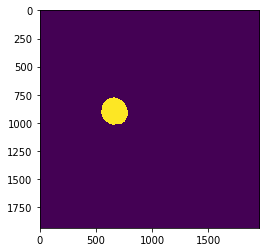

  6%|▋         | 17/265 [00:06<01:29,  2.76it/s]

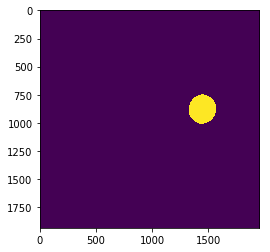

  7%|▋         | 18/265 [00:06<01:28,  2.79it/s]

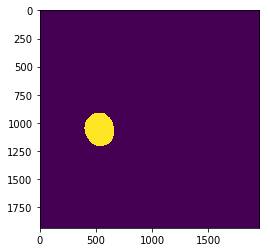

  7%|▋         | 19/265 [00:06<01:28,  2.79it/s]

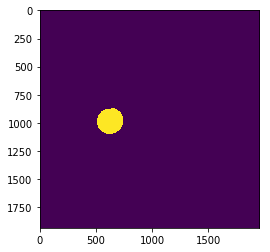

  8%|▊         | 20/265 [00:07<01:27,  2.81it/s]

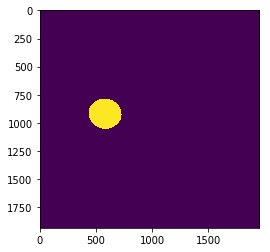

  8%|▊         | 21/265 [00:07<01:26,  2.83it/s]

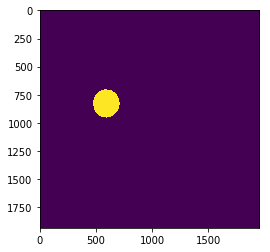

  8%|▊         | 22/265 [00:07<01:25,  2.86it/s]

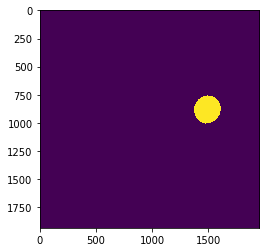

  9%|▊         | 23/265 [00:08<01:24,  2.86it/s]

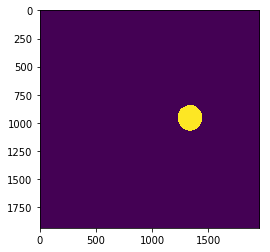

  9%|▉         | 24/265 [00:08<01:23,  2.87it/s]

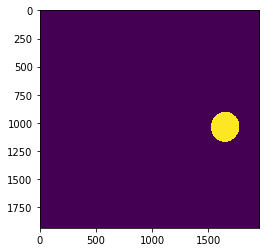

  9%|▉         | 25/265 [00:08<01:23,  2.89it/s]

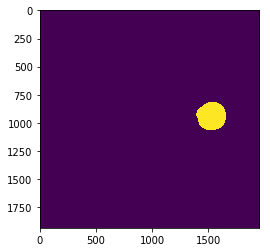

 10%|▉         | 26/265 [00:08<01:22,  2.89it/s]

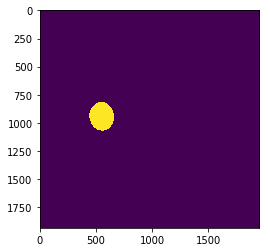

 10%|█         | 27/265 [00:09<01:22,  2.90it/s]

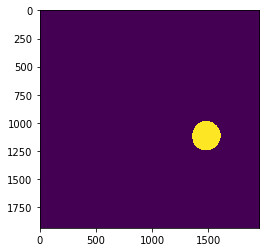

 11%|█         | 28/265 [00:09<01:21,  2.92it/s]

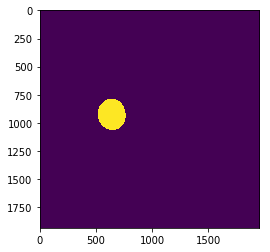

 11%|█         | 29/265 [00:09<01:20,  2.93it/s]

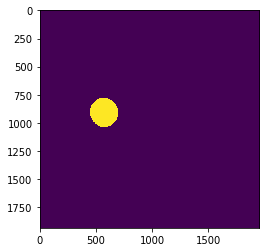

 11%|█▏        | 30/265 [00:10<01:20,  2.93it/s]

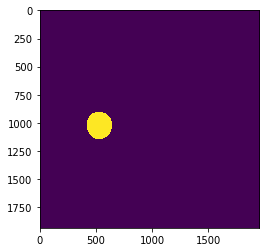

 12%|█▏        | 31/265 [00:10<01:19,  2.93it/s]

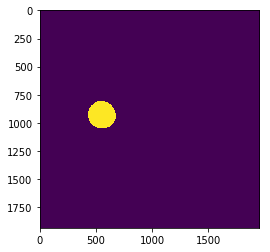

 12%|█▏        | 32/265 [00:10<01:19,  2.94it/s]

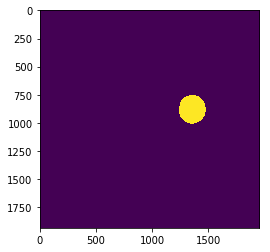

 12%|█▏        | 33/265 [00:11<01:18,  2.95it/s]

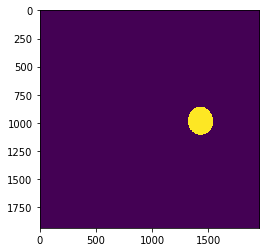

 13%|█▎        | 34/265 [00:11<01:17,  2.96it/s]

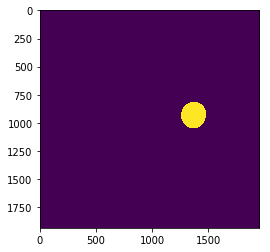

 13%|█▎        | 35/265 [00:11<01:17,  2.96it/s]

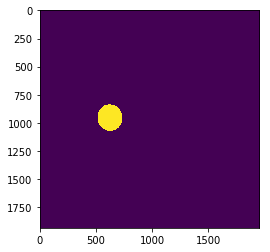

 14%|█▎        | 36/265 [00:12<01:17,  2.97it/s]

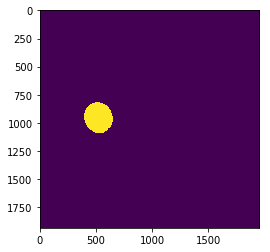

 14%|█▍        | 37/265 [00:12<01:16,  2.98it/s]

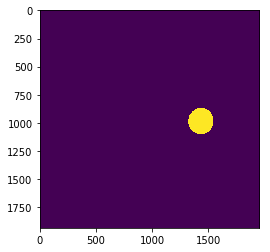

 14%|█▍        | 38/265 [00:12<01:15,  2.99it/s]

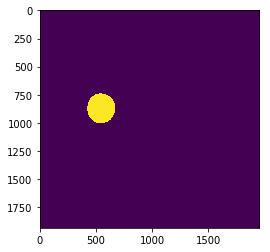

 15%|█▍        | 39/265 [00:13<01:15,  3.00it/s]

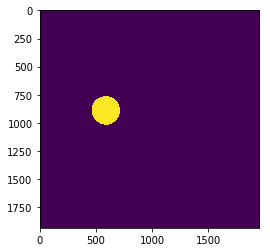

 15%|█▌        | 40/265 [00:13<01:14,  3.01it/s]

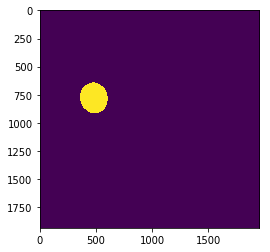

 15%|█▌        | 41/265 [00:13<01:14,  3.01it/s]

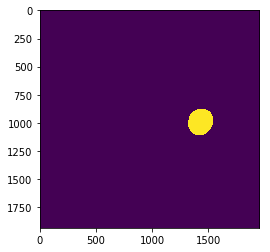

 16%|█▌        | 42/265 [00:13<01:13,  3.02it/s]

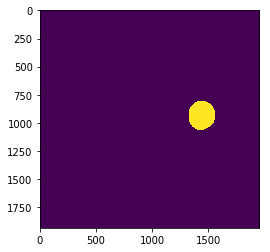

 16%|█▌        | 43/265 [00:14<01:13,  3.03it/s]

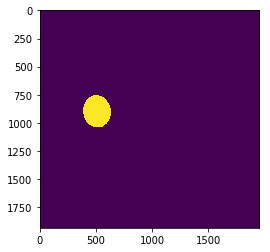

 17%|█▋        | 44/265 [00:14<01:12,  3.04it/s]

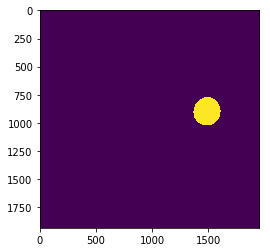

 17%|█▋        | 45/265 [00:14<01:12,  3.04it/s]

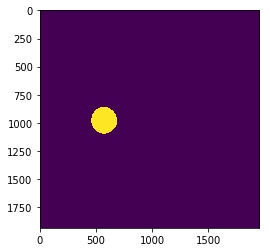

 17%|█▋        | 46/265 [00:15<01:11,  3.05it/s]

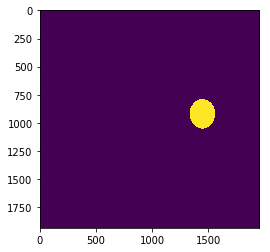

 18%|█▊        | 47/265 [00:15<01:11,  3.06it/s]

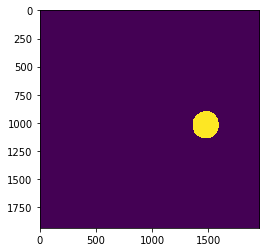

 18%|█▊        | 48/265 [00:15<01:10,  3.06it/s]

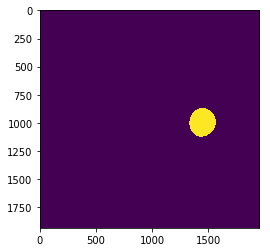

 18%|█▊        | 49/265 [00:16<01:10,  3.06it/s]

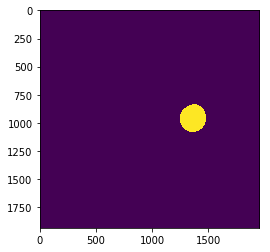

 19%|█▉        | 50/265 [00:16<01:10,  3.05it/s]

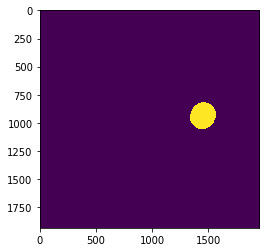

 19%|█▉        | 51/265 [00:16<01:10,  3.05it/s]

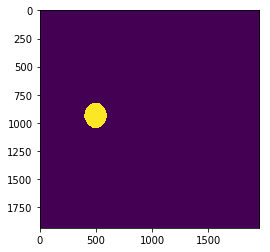

 20%|█▉        | 52/265 [00:17<01:09,  3.04it/s]

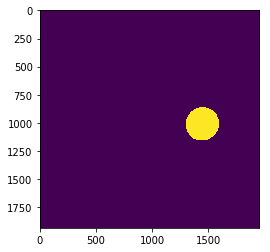

 20%|██        | 53/265 [00:17<01:09,  3.05it/s]

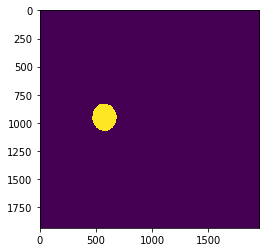

 20%|██        | 54/265 [00:17<01:09,  3.06it/s]

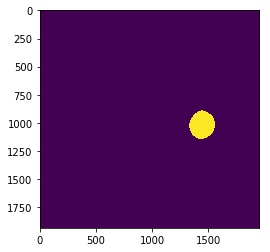

 21%|██        | 55/265 [00:17<01:08,  3.06it/s]

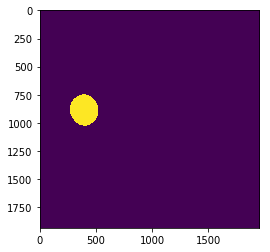

 21%|██        | 56/265 [00:18<01:08,  3.06it/s]

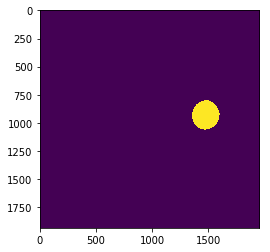

 22%|██▏       | 57/265 [00:18<01:08,  3.06it/s]

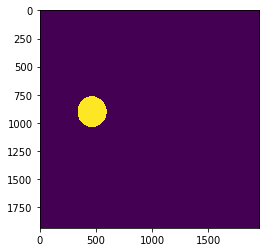

 22%|██▏       | 58/265 [00:18<01:07,  3.05it/s]

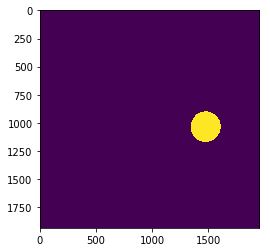

 22%|██▏       | 59/265 [00:19<01:07,  3.06it/s]

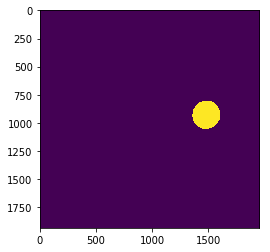

 23%|██▎       | 60/265 [00:19<01:07,  3.06it/s]

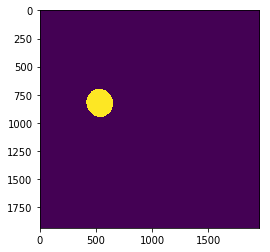

 23%|██▎       | 61/265 [00:19<01:06,  3.06it/s]

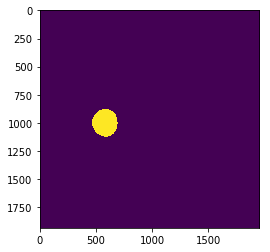

 23%|██▎       | 62/265 [00:20<01:06,  3.06it/s]

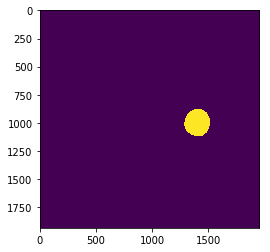

 24%|██▍       | 63/265 [00:20<01:05,  3.07it/s]

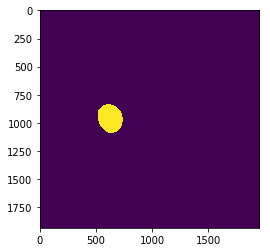

 24%|██▍       | 64/265 [00:20<01:05,  3.07it/s]

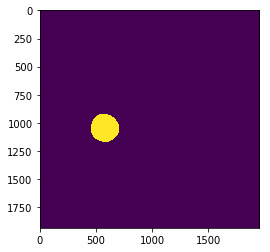

 25%|██▍       | 65/265 [00:21<01:04,  3.08it/s]

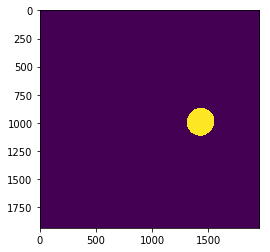

 25%|██▍       | 66/265 [00:21<01:04,  3.08it/s]

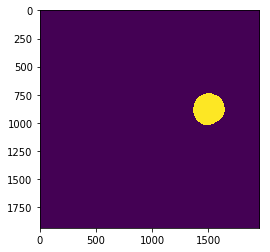

 25%|██▌       | 67/265 [00:21<01:04,  3.09it/s]

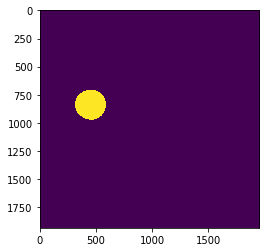

 26%|██▌       | 68/265 [00:22<01:03,  3.09it/s]

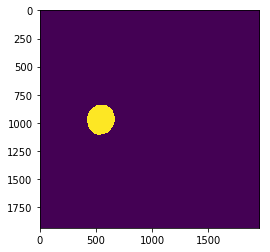

 26%|██▌       | 69/265 [00:22<01:03,  3.09it/s]

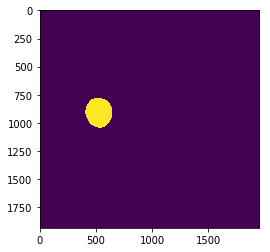

 26%|██▋       | 70/265 [00:22<01:02,  3.10it/s]

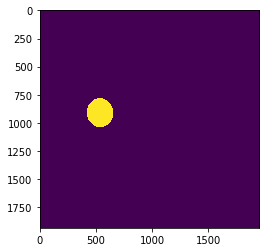

 27%|██▋       | 71/265 [00:22<01:02,  3.10it/s]

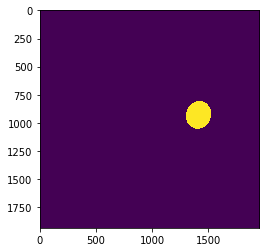

 27%|██▋       | 72/265 [00:23<01:02,  3.11it/s]

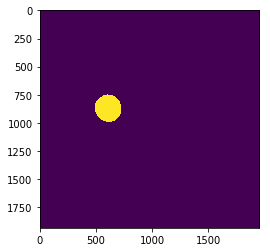

 28%|██▊       | 73/265 [00:23<01:01,  3.11it/s]

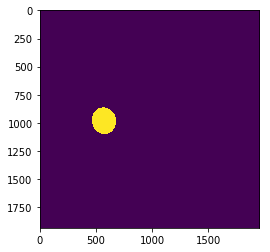

 28%|██▊       | 74/265 [00:23<01:01,  3.11it/s]

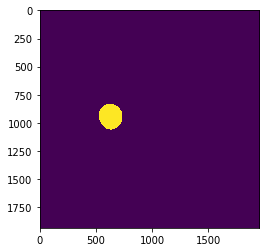

 28%|██▊       | 75/265 [00:24<01:00,  3.12it/s]

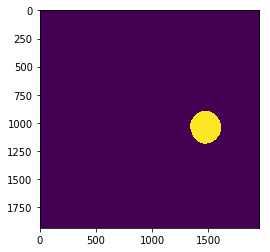

 29%|██▊       | 76/265 [00:24<01:00,  3.12it/s]

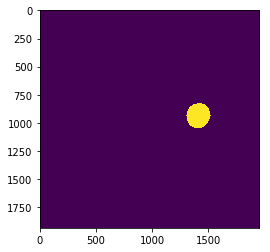

 29%|██▉       | 77/265 [00:24<01:00,  3.12it/s]

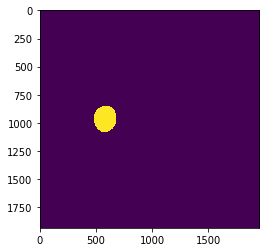

 29%|██▉       | 78/265 [00:25<00:59,  3.12it/s]

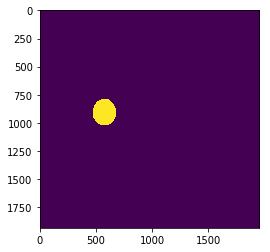

 30%|██▉       | 79/265 [00:25<00:59,  3.12it/s]

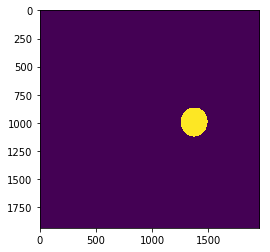

 30%|███       | 80/265 [00:25<00:59,  3.13it/s]

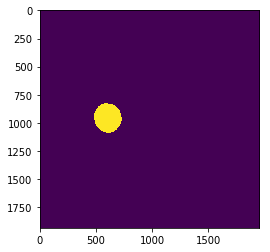

 31%|███       | 81/265 [00:25<00:58,  3.12it/s]

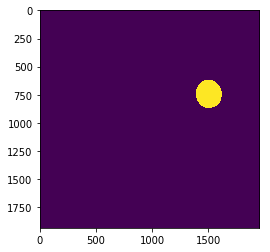

 31%|███       | 82/265 [00:26<00:58,  3.13it/s]

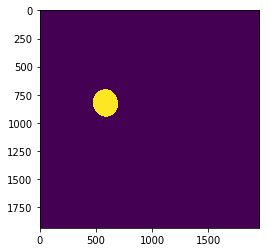

 31%|███▏      | 83/265 [00:26<00:58,  3.13it/s]

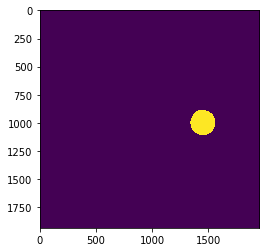

 32%|███▏      | 84/265 [00:26<00:57,  3.13it/s]

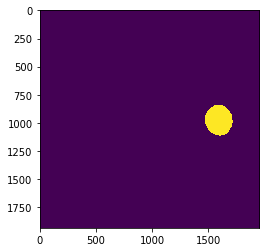

 32%|███▏      | 85/265 [00:27<00:57,  3.13it/s]

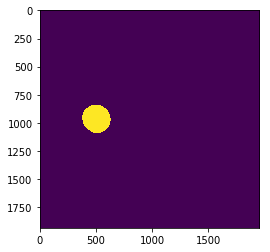

 32%|███▏      | 86/265 [00:27<00:57,  3.14it/s]

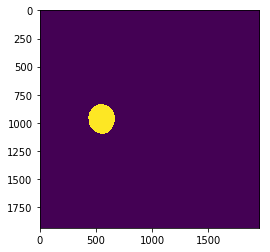

 33%|███▎      | 87/265 [00:27<00:56,  3.14it/s]

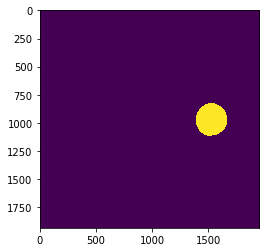

 33%|███▎      | 88/265 [00:28<00:56,  3.14it/s]

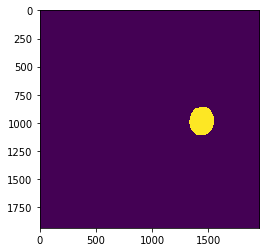

 34%|███▎      | 89/265 [00:28<00:56,  3.14it/s]

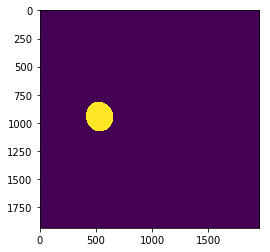

 34%|███▍      | 90/265 [00:28<00:55,  3.14it/s]

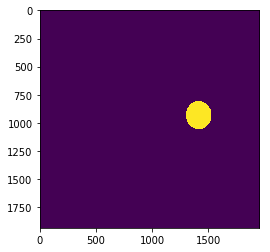

 34%|███▍      | 91/265 [00:28<00:55,  3.15it/s]

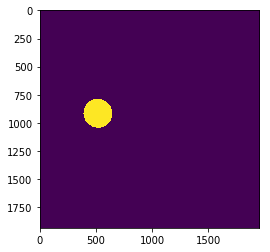

 35%|███▍      | 92/265 [00:29<00:54,  3.15it/s]

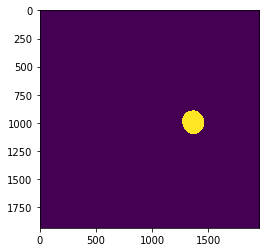

 35%|███▌      | 93/265 [00:29<00:54,  3.15it/s]

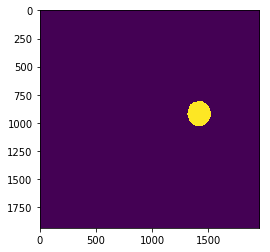

 35%|███▌      | 94/265 [00:29<00:54,  3.15it/s]

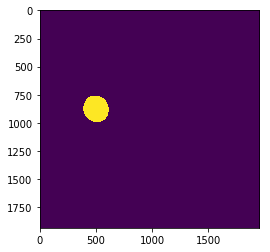

 36%|███▌      | 95/265 [00:30<00:53,  3.16it/s]

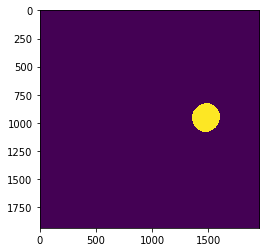

 36%|███▌      | 96/265 [00:30<00:53,  3.15it/s]

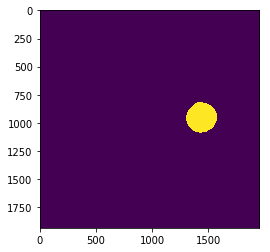

 37%|███▋      | 97/265 [00:30<00:53,  3.15it/s]

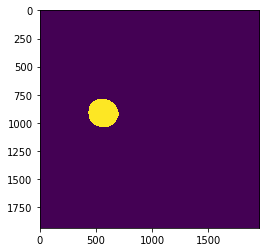

 37%|███▋      | 98/265 [00:31<00:52,  3.16it/s]

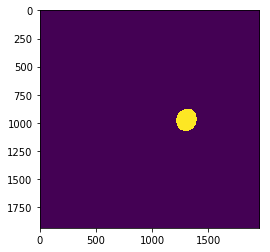

 37%|███▋      | 99/265 [00:31<00:52,  3.16it/s]

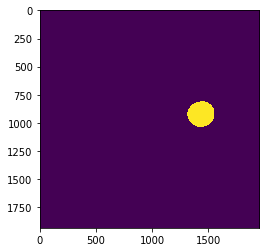

 38%|███▊      | 100/265 [00:31<00:52,  3.16it/s]

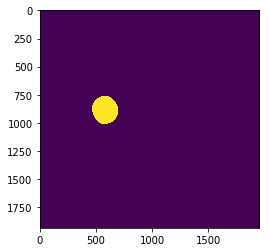

 38%|███▊      | 101/265 [00:31<00:51,  3.16it/s]

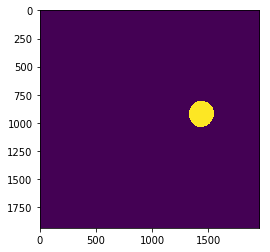

 38%|███▊      | 102/265 [00:32<00:51,  3.16it/s]

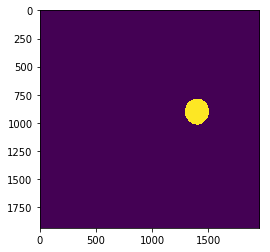

 39%|███▉      | 103/265 [00:32<00:51,  3.16it/s]

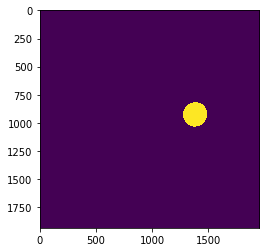

 39%|███▉      | 104/265 [00:32<00:50,  3.16it/s]

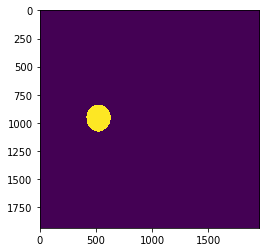

 40%|███▉      | 105/265 [00:33<00:50,  3.17it/s]

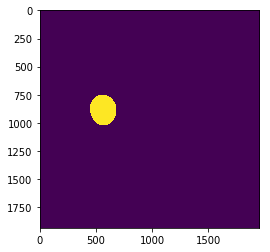

 40%|████      | 106/265 [00:33<00:50,  3.17it/s]

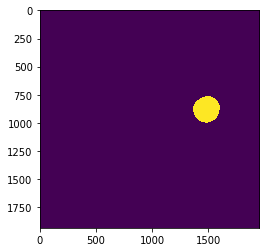

 40%|████      | 107/265 [00:33<00:49,  3.17it/s]

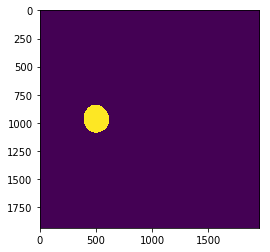

 41%|████      | 108/265 [00:34<00:49,  3.17it/s]

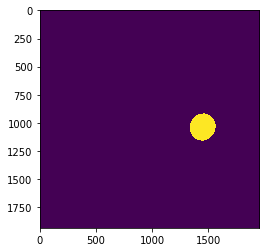

 41%|████      | 109/265 [00:34<00:49,  3.15it/s]

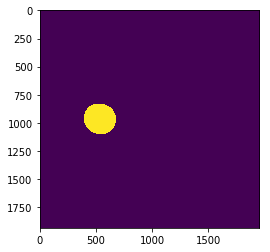

 42%|████▏     | 110/265 [00:34<00:49,  3.15it/s]

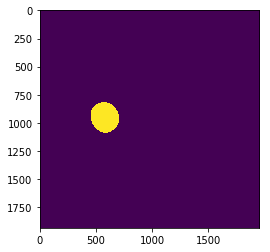

 42%|████▏     | 111/265 [00:35<00:48,  3.15it/s]

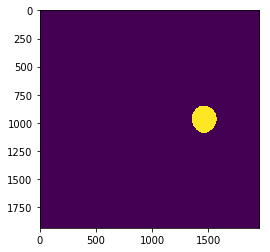

 42%|████▏     | 112/265 [00:35<00:48,  3.15it/s]

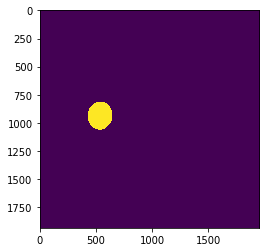

 43%|████▎     | 113/265 [00:35<00:48,  3.16it/s]

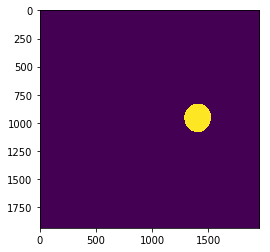

 43%|████▎     | 114/265 [00:36<00:47,  3.16it/s]

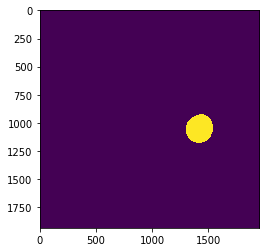

 43%|████▎     | 115/265 [00:36<00:47,  3.16it/s]

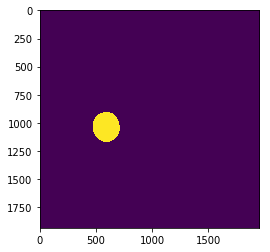

 44%|████▍     | 116/265 [00:36<00:47,  3.16it/s]

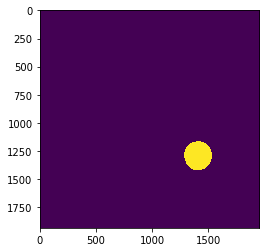

 44%|████▍     | 117/265 [00:36<00:46,  3.17it/s]

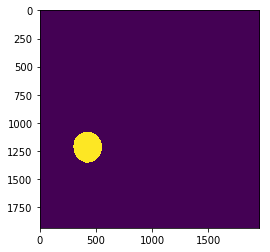

 45%|████▍     | 118/265 [00:37<00:46,  3.17it/s]

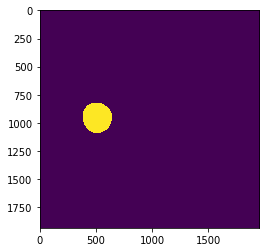

 45%|████▍     | 119/265 [00:37<00:46,  3.17it/s]

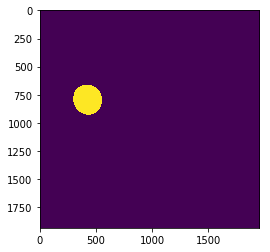

 45%|████▌     | 120/265 [00:37<00:45,  3.17it/s]

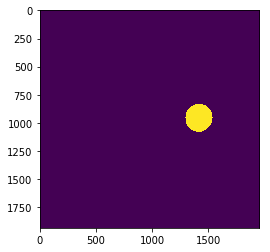

 46%|████▌     | 121/265 [00:38<00:45,  3.18it/s]

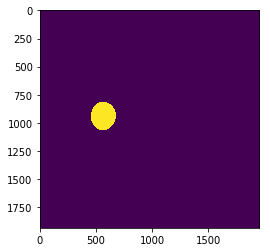

 46%|████▌     | 122/265 [00:38<00:45,  3.18it/s]

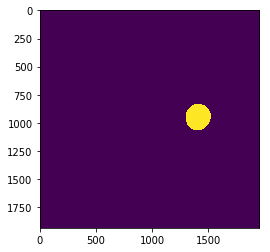

 46%|████▋     | 123/265 [00:38<00:44,  3.18it/s]

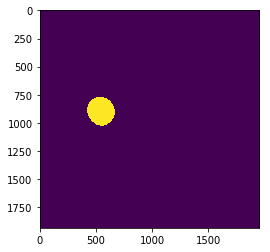

 47%|████▋     | 124/265 [00:38<00:44,  3.18it/s]

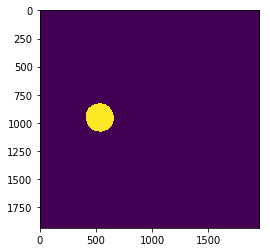

 47%|████▋     | 125/265 [00:39<00:43,  3.18it/s]

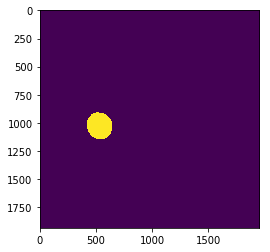

 48%|████▊     | 126/265 [00:39<00:43,  3.18it/s]

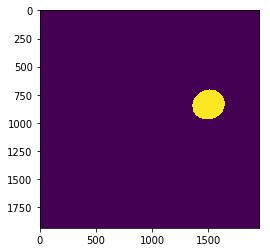

 48%|████▊     | 127/265 [00:39<00:43,  3.18it/s]

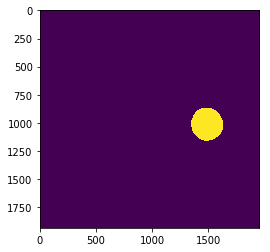

 48%|████▊     | 128/265 [00:40<00:43,  3.18it/s]

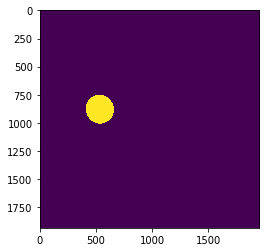

 49%|████▊     | 129/265 [00:40<00:42,  3.18it/s]

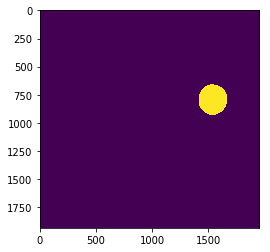

 49%|████▉     | 130/265 [00:40<00:42,  3.18it/s]

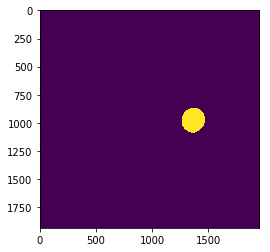

 49%|████▉     | 131/265 [00:41<00:42,  3.19it/s]

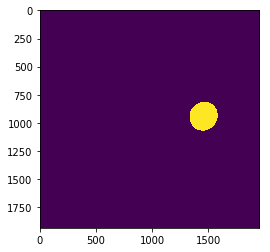

 50%|████▉     | 132/265 [00:41<00:41,  3.19it/s]

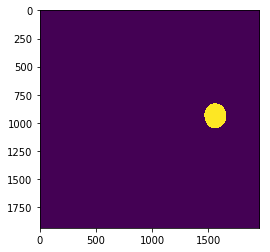

 50%|█████     | 133/265 [00:41<00:41,  3.19it/s]

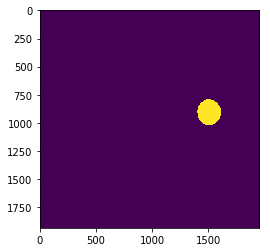

 51%|█████     | 134/265 [00:41<00:41,  3.19it/s]

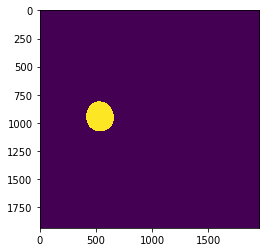

 51%|█████     | 135/265 [00:42<00:40,  3.19it/s]

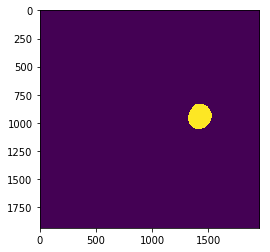

 51%|█████▏    | 136/265 [00:42<00:40,  3.20it/s]

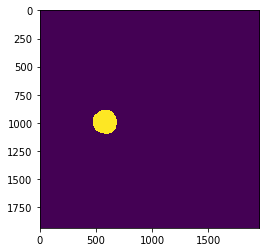

 52%|█████▏    | 137/265 [00:42<00:40,  3.20it/s]

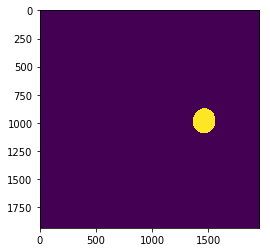

 52%|█████▏    | 138/265 [00:43<00:39,  3.20it/s]

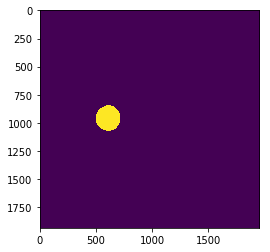

 52%|█████▏    | 139/265 [00:43<00:39,  3.20it/s]

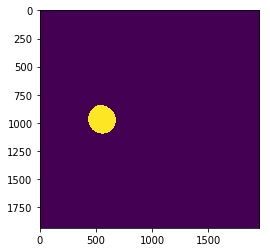

 53%|█████▎    | 140/265 [00:43<00:39,  3.20it/s]

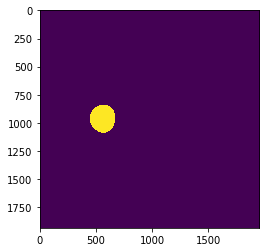

 53%|█████▎    | 141/265 [00:44<00:38,  3.20it/s]

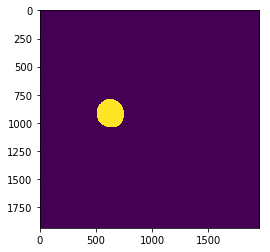

 54%|█████▎    | 142/265 [00:44<00:38,  3.21it/s]

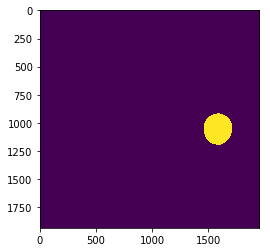

 54%|█████▍    | 143/265 [00:44<00:38,  3.21it/s]

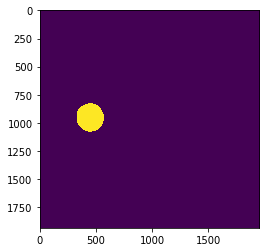

 54%|█████▍    | 144/265 [00:44<00:37,  3.21it/s]

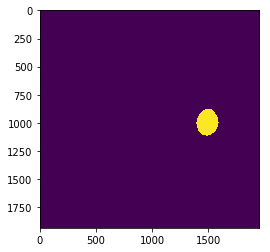

 55%|█████▍    | 145/265 [00:45<00:37,  3.21it/s]

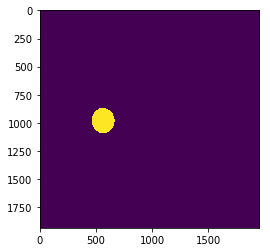

 55%|█████▌    | 146/265 [00:45<00:37,  3.21it/s]

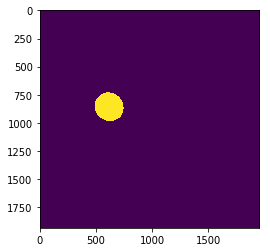

 55%|█████▌    | 147/265 [00:45<00:36,  3.22it/s]

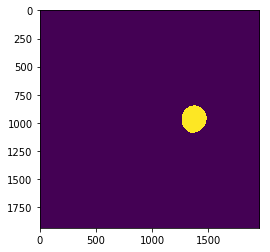

 56%|█████▌    | 148/265 [00:46<00:36,  3.22it/s]

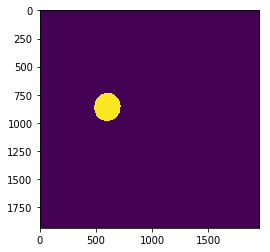

 56%|█████▌    | 149/265 [00:46<00:36,  3.22it/s]

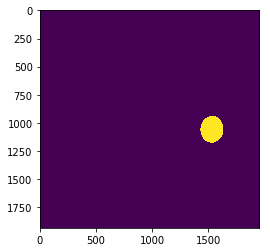

 57%|█████▋    | 150/265 [00:46<00:35,  3.22it/s]

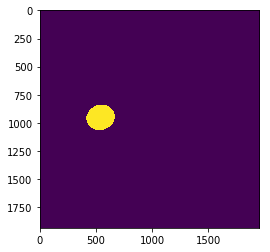

 57%|█████▋    | 151/265 [00:46<00:35,  3.22it/s]

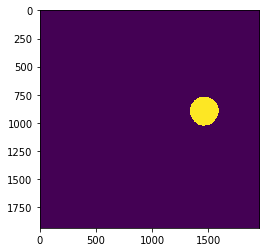

 57%|█████▋    | 152/265 [00:47<00:35,  3.22it/s]

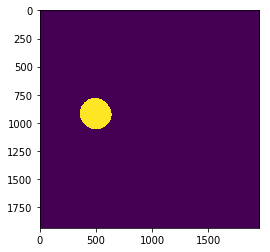

 58%|█████▊    | 153/265 [00:47<00:34,  3.22it/s]

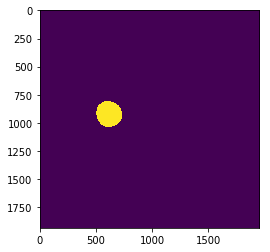

 58%|█████▊    | 154/265 [00:47<00:34,  3.22it/s]

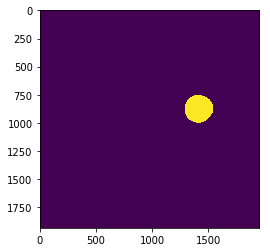

 58%|█████▊    | 155/265 [00:48<00:34,  3.22it/s]

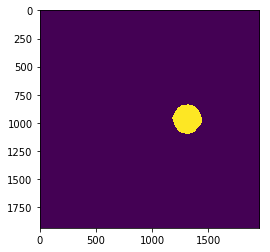

 59%|█████▉    | 156/265 [00:48<00:33,  3.22it/s]

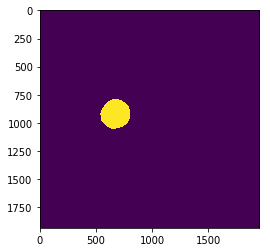

 59%|█████▉    | 157/265 [00:48<00:33,  3.22it/s]

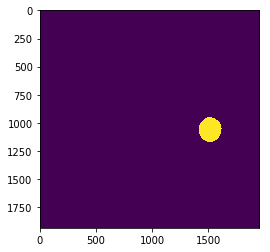

 60%|█████▉    | 158/265 [00:48<00:33,  3.23it/s]

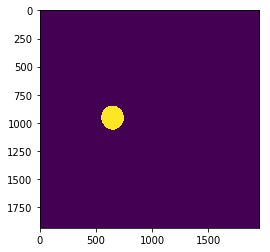

 60%|██████    | 159/265 [00:49<00:32,  3.23it/s]

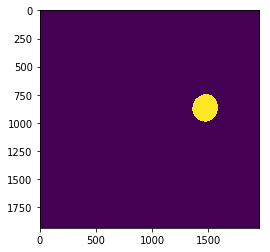

 60%|██████    | 160/265 [00:49<00:32,  3.23it/s]

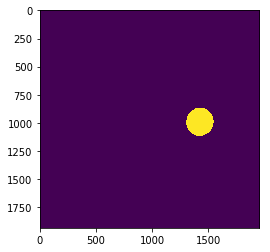

 61%|██████    | 161/265 [00:49<00:32,  3.23it/s]

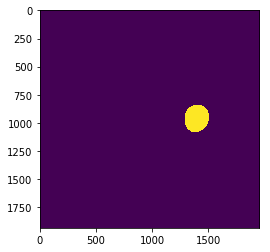

 61%|██████    | 162/265 [00:50<00:31,  3.23it/s]

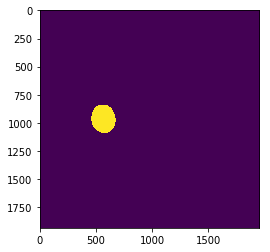

 62%|██████▏   | 163/265 [00:50<00:31,  3.23it/s]

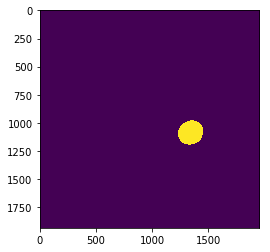

 62%|██████▏   | 164/265 [00:50<00:31,  3.23it/s]

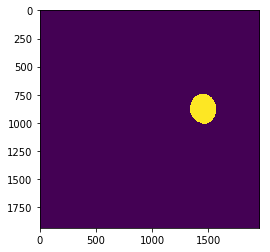

 62%|██████▏   | 165/265 [00:51<00:30,  3.23it/s]

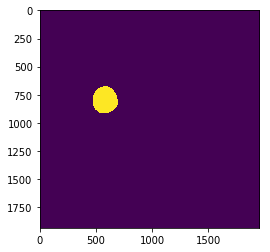

 63%|██████▎   | 166/265 [00:51<00:30,  3.23it/s]

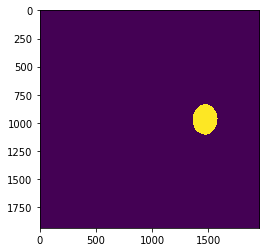

 63%|██████▎   | 167/265 [00:51<00:30,  3.23it/s]

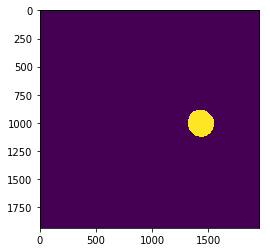

 63%|██████▎   | 168/265 [00:52<00:30,  3.23it/s]

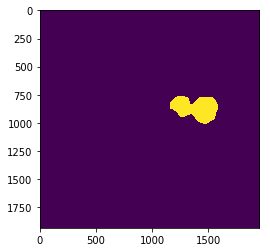

 64%|██████▍   | 169/265 [00:52<00:29,  3.23it/s]

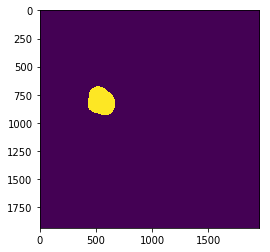

 64%|██████▍   | 170/265 [00:52<00:29,  3.23it/s]

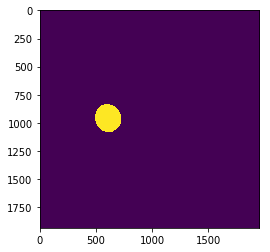

 65%|██████▍   | 171/265 [00:52<00:29,  3.23it/s]

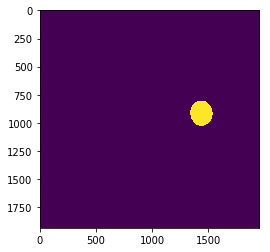

 65%|██████▍   | 172/265 [00:53<00:28,  3.23it/s]

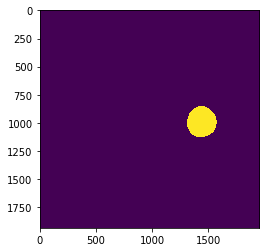

 65%|██████▌   | 173/265 [00:53<00:28,  3.23it/s]

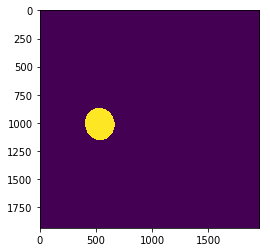

 66%|██████▌   | 174/265 [00:53<00:28,  3.23it/s]

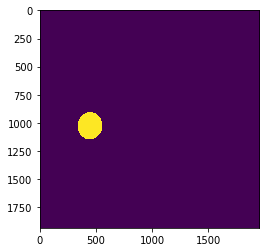

 66%|██████▌   | 175/265 [00:54<00:27,  3.23it/s]

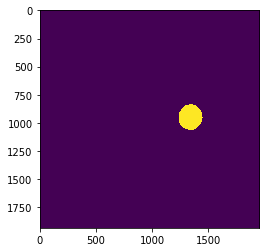

 66%|██████▋   | 176/265 [00:54<00:27,  3.23it/s]

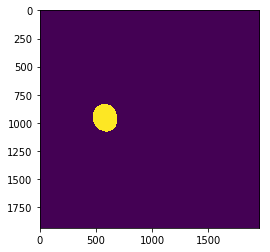

 67%|██████▋   | 177/265 [00:54<00:27,  3.23it/s]

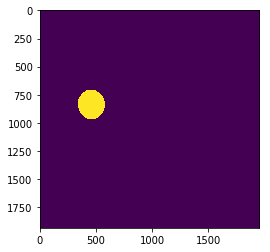

 67%|██████▋   | 178/265 [00:55<00:26,  3.23it/s]

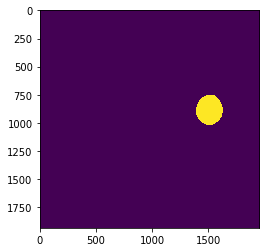

 68%|██████▊   | 179/265 [00:55<00:26,  3.23it/s]

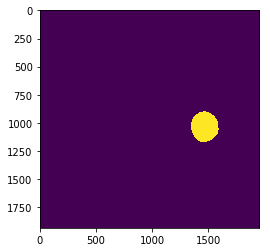

 68%|██████▊   | 180/265 [00:55<00:26,  3.24it/s]

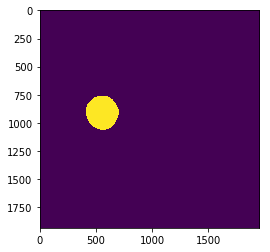

 68%|██████▊   | 181/265 [00:55<00:25,  3.23it/s]

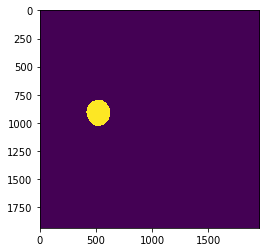

 69%|██████▊   | 182/265 [00:56<00:25,  3.23it/s]

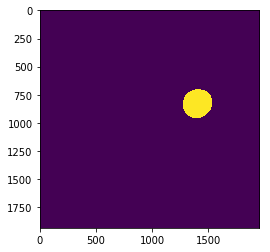

 69%|██████▉   | 183/265 [00:56<00:25,  3.24it/s]

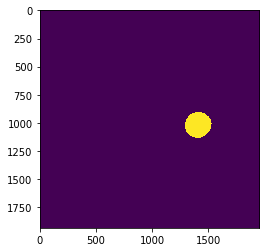

 69%|██████▉   | 184/265 [00:56<00:25,  3.24it/s]

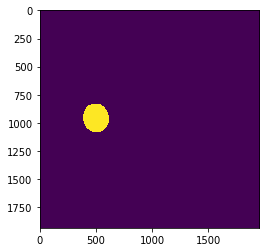

 70%|██████▉   | 185/265 [00:57<00:24,  3.24it/s]

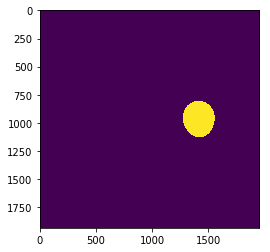

 70%|███████   | 186/265 [00:57<00:24,  3.24it/s]

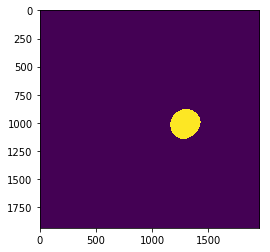

 71%|███████   | 187/265 [00:57<00:24,  3.24it/s]

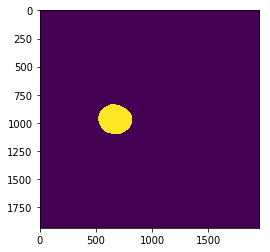

 71%|███████   | 188/265 [00:58<00:23,  3.24it/s]

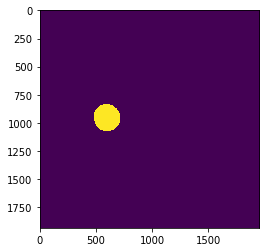

 71%|███████▏  | 189/265 [00:58<00:23,  3.24it/s]

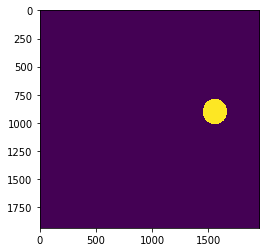

 72%|███████▏  | 190/265 [00:58<00:23,  3.24it/s]

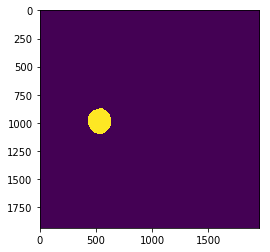

 72%|███████▏  | 191/265 [00:58<00:22,  3.24it/s]

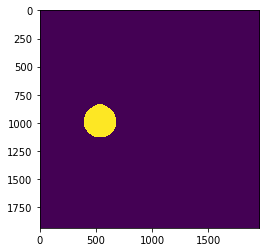

 72%|███████▏  | 192/265 [00:59<00:22,  3.24it/s]

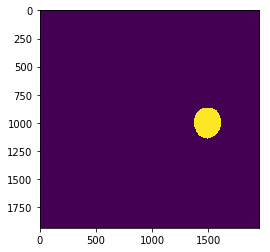

 73%|███████▎  | 193/265 [00:59<00:22,  3.23it/s]

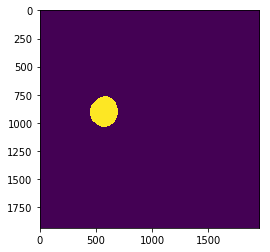

 73%|███████▎  | 194/265 [00:59<00:21,  3.23it/s]

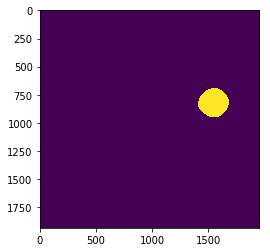

 74%|███████▎  | 195/265 [01:00<00:21,  3.23it/s]

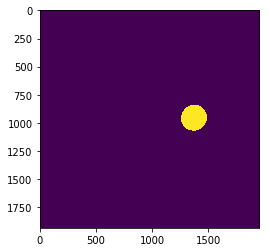

 74%|███████▍  | 196/265 [01:00<00:21,  3.23it/s]

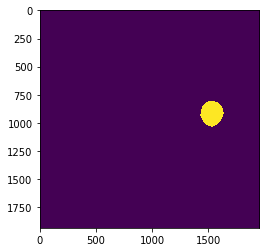

 74%|███████▍  | 197/265 [01:00<00:21,  3.23it/s]

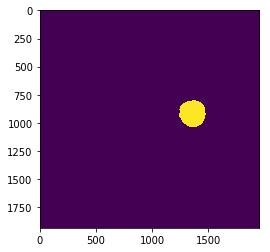

 75%|███████▍  | 198/265 [01:01<00:20,  3.24it/s]

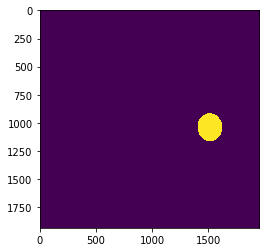

 75%|███████▌  | 199/265 [01:01<00:20,  3.24it/s]

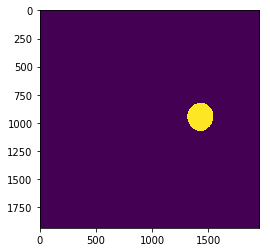

 75%|███████▌  | 200/265 [01:01<00:20,  3.24it/s]

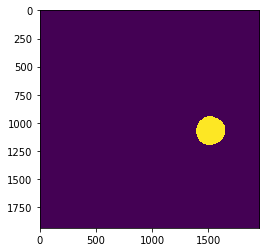

 76%|███████▌  | 201/265 [01:02<00:19,  3.24it/s]

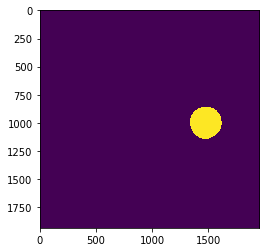

 76%|███████▌  | 202/265 [01:02<00:19,  3.23it/s]

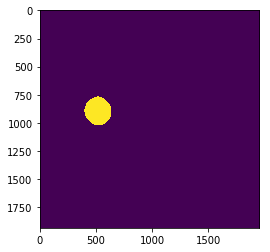

 77%|███████▋  | 203/265 [01:02<00:19,  3.24it/s]

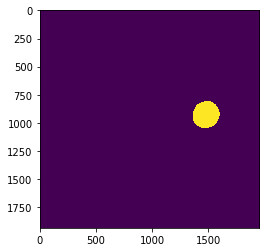

 77%|███████▋  | 204/265 [01:03<00:18,  3.24it/s]

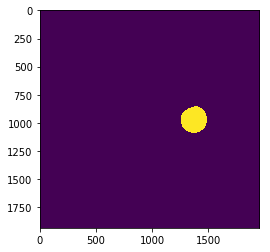

 77%|███████▋  | 205/265 [01:03<00:18,  3.24it/s]

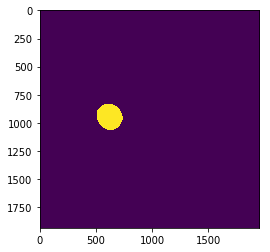

 78%|███████▊  | 206/265 [01:03<00:18,  3.24it/s]

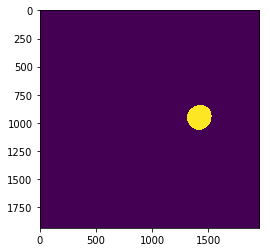

 78%|███████▊  | 207/265 [01:03<00:17,  3.23it/s]

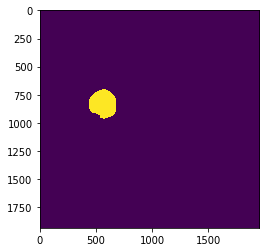

 78%|███████▊  | 208/265 [01:04<00:17,  3.23it/s]

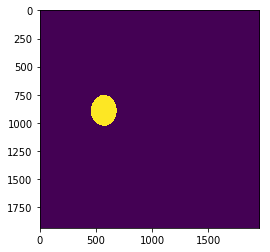

 79%|███████▉  | 209/265 [01:04<00:17,  3.23it/s]

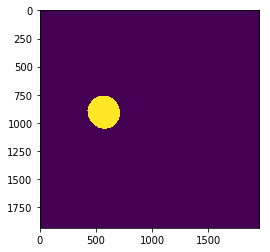

 79%|███████▉  | 210/265 [01:04<00:17,  3.23it/s]

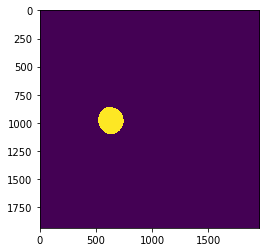

 80%|███████▉  | 211/265 [01:05<00:16,  3.23it/s]

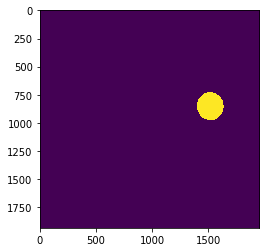

 80%|████████  | 212/265 [01:05<00:16,  3.24it/s]

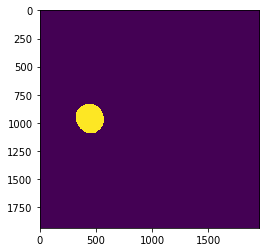

 80%|████████  | 213/265 [01:05<00:16,  3.24it/s]

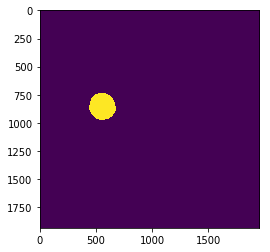

 81%|████████  | 214/265 [01:06<00:15,  3.24it/s]

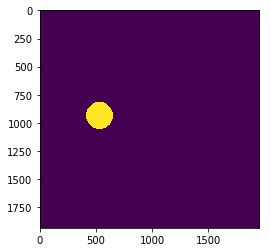

 81%|████████  | 215/265 [01:06<00:15,  3.24it/s]

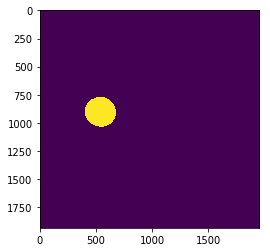

 82%|████████▏ | 216/265 [01:06<00:15,  3.24it/s]

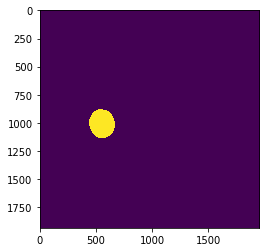

 82%|████████▏ | 217/265 [01:06<00:14,  3.24it/s]

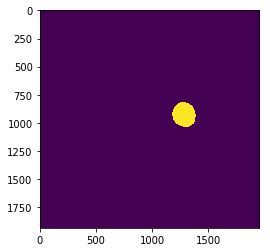

 82%|████████▏ | 218/265 [01:07<00:14,  3.24it/s]

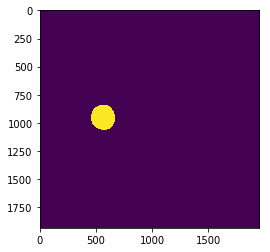

 83%|████████▎ | 219/265 [01:07<00:14,  3.24it/s]

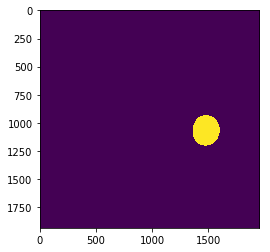

 83%|████████▎ | 220/265 [01:07<00:13,  3.24it/s]

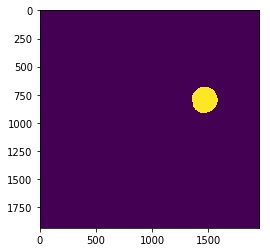

 83%|████████▎ | 221/265 [01:08<00:13,  3.24it/s]

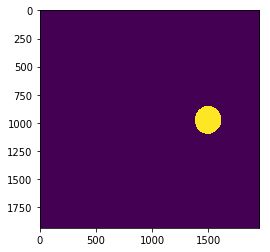

 84%|████████▍ | 222/265 [01:08<00:13,  3.22it/s]

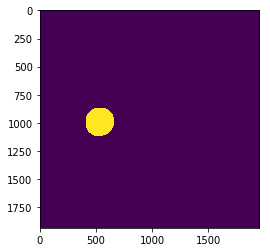

 84%|████████▍ | 223/265 [01:09<00:13,  3.23it/s]

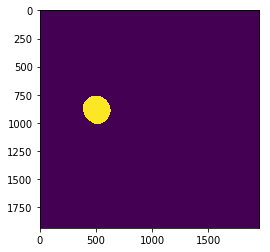

 85%|████████▍ | 224/265 [01:09<00:12,  3.23it/s]

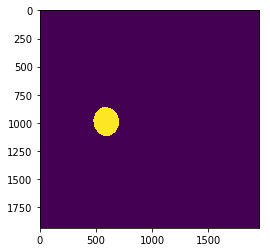

 85%|████████▍ | 225/265 [01:09<00:12,  3.23it/s]

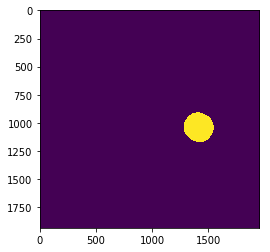

 85%|████████▌ | 226/265 [01:10<00:12,  3.23it/s]

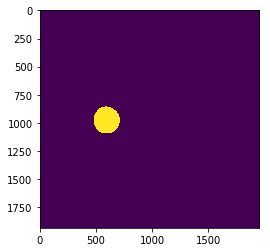

 86%|████████▌ | 227/265 [01:10<00:11,  3.23it/s]

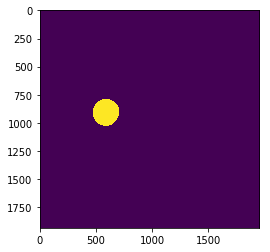

 86%|████████▌ | 228/265 [01:10<00:11,  3.23it/s]

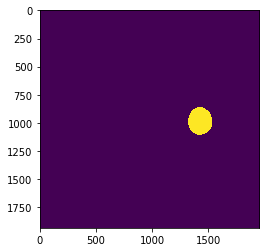

 86%|████████▋ | 229/265 [01:10<00:11,  3.23it/s]

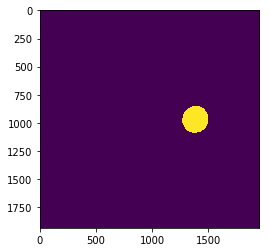

 87%|████████▋ | 230/265 [01:11<00:10,  3.23it/s]

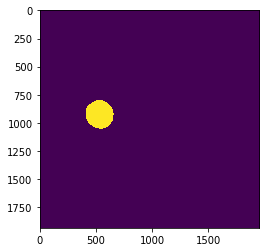

 87%|████████▋ | 231/265 [01:11<00:10,  3.23it/s]

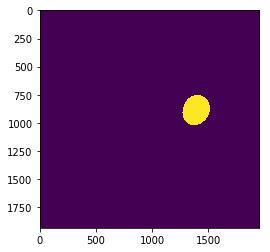

 88%|████████▊ | 232/265 [01:11<00:10,  3.23it/s]

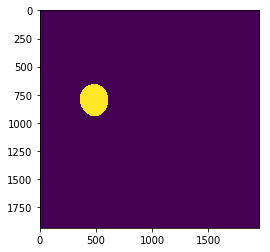

 88%|████████▊ | 233/265 [01:12<00:09,  3.23it/s]

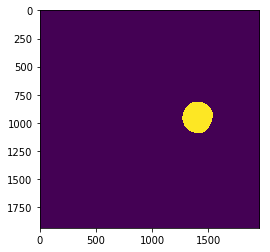

 88%|████████▊ | 234/265 [01:12<00:09,  3.23it/s]

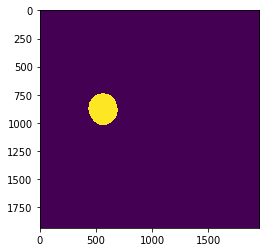

 89%|████████▊ | 235/265 [01:12<00:09,  3.23it/s]

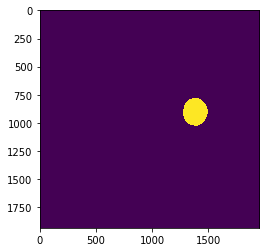

 89%|████████▉ | 236/265 [01:12<00:08,  3.23it/s]

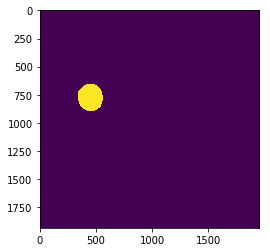

 89%|████████▉ | 237/265 [01:13<00:08,  3.24it/s]

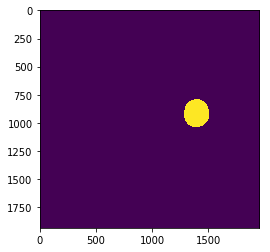

 90%|████████▉ | 238/265 [01:13<00:08,  3.24it/s]

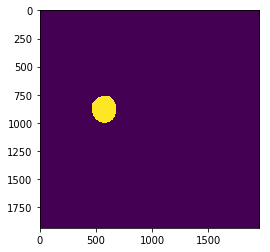

 90%|█████████ | 239/265 [01:13<00:08,  3.24it/s]

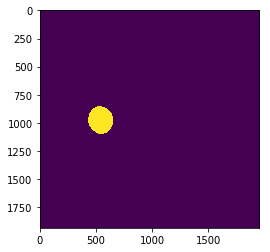

 91%|█████████ | 240/265 [01:14<00:07,  3.24it/s]

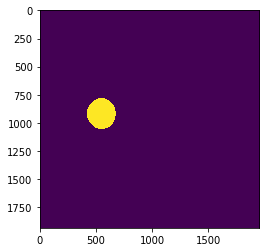

 91%|█████████ | 241/265 [01:14<00:07,  3.24it/s]

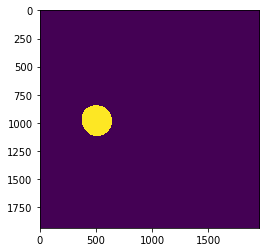

 91%|█████████▏| 242/265 [01:14<00:07,  3.24it/s]

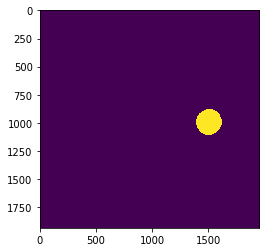

 92%|█████████▏| 243/265 [01:14<00:06,  3.24it/s]

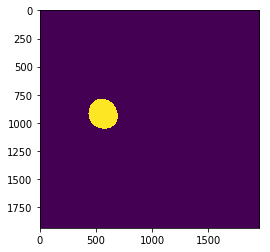

 92%|█████████▏| 244/265 [01:15<00:06,  3.24it/s]

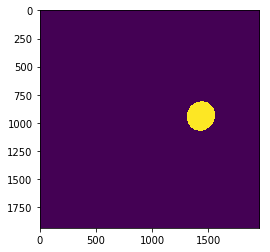

 92%|█████████▏| 245/265 [01:15<00:06,  3.24it/s]

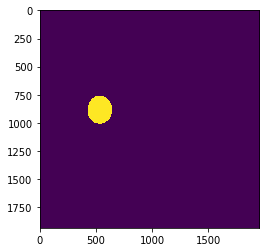

 93%|█████████▎| 246/265 [01:15<00:05,  3.24it/s]

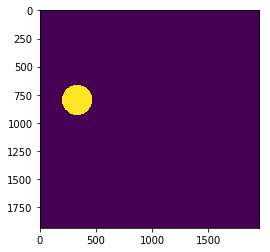

 93%|█████████▎| 247/265 [01:16<00:05,  3.24it/s]

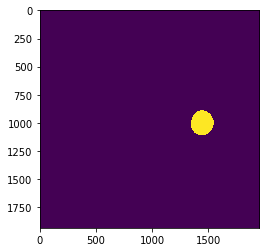

 94%|█████████▎| 248/265 [01:16<00:05,  3.24it/s]

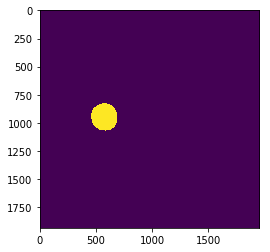

 94%|█████████▍| 249/265 [01:16<00:04,  3.24it/s]

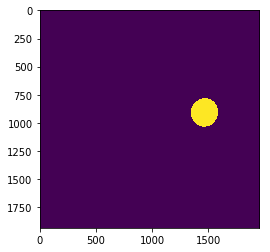

 94%|█████████▍| 250/265 [01:17<00:04,  3.24it/s]

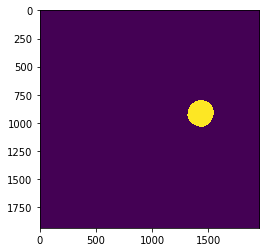

 95%|█████████▍| 251/265 [01:17<00:04,  3.25it/s]

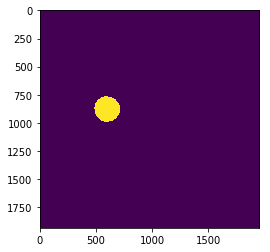

 95%|█████████▌| 252/265 [01:17<00:04,  3.25it/s]

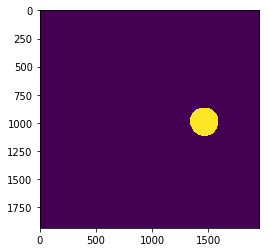

 95%|█████████▌| 253/265 [01:17<00:03,  3.25it/s]

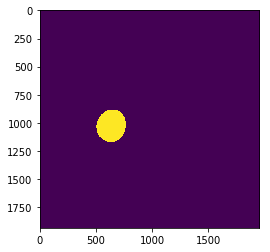

 96%|█████████▌| 254/265 [01:18<00:03,  3.24it/s]

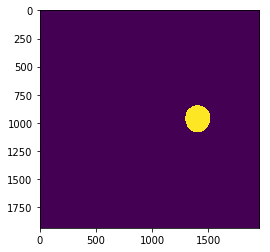

 96%|█████████▌| 255/265 [01:18<00:03,  3.25it/s]

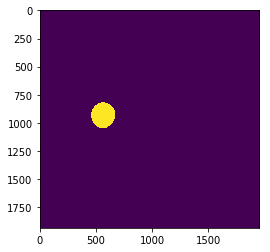

 97%|█████████▋| 256/265 [01:18<00:02,  3.25it/s]

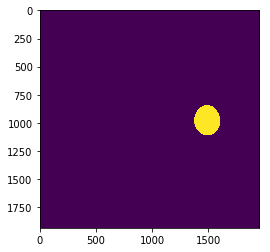

 97%|█████████▋| 257/265 [01:19<00:02,  3.25it/s]

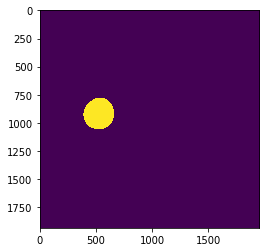

 97%|█████████▋| 258/265 [01:19<00:02,  3.25it/s]

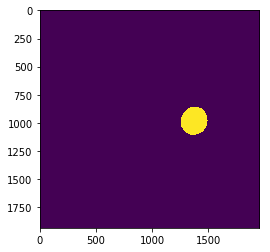

 98%|█████████▊| 259/265 [01:19<00:01,  3.25it/s]

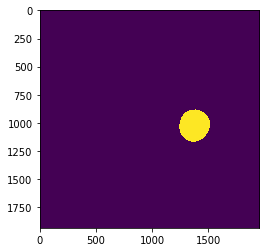

 98%|█████████▊| 260/265 [01:20<00:01,  3.25it/s]

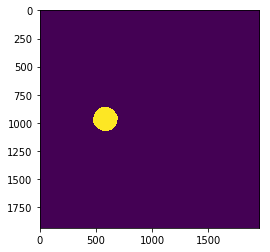

 98%|█████████▊| 261/265 [01:20<00:01,  3.25it/s]

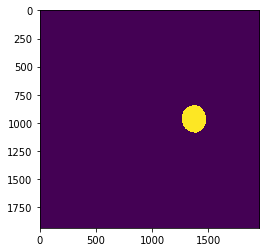

 99%|█████████▉| 262/265 [01:20<00:00,  3.25it/s]

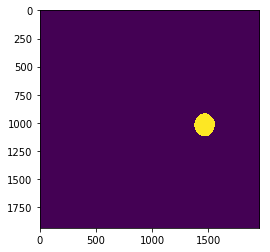

 99%|█████████▉| 263/265 [01:20<00:00,  3.25it/s]

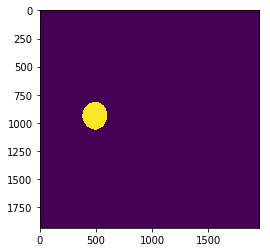

100%|█████████▉| 264/265 [01:21<00:00,  3.25it/s]

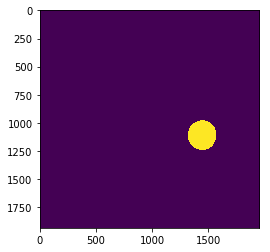

100%|██████████| 265/265 [01:21<00:00,  3.25it/s]


In [35]:
import matplotlib.pyplot as plt

print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), val_batch_size))
for start in tqdm(range(0, len(ids_test), val_batch_size)):
    x_batch = []
    end = min(start + val_batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    for id in ids_test_batch.values:
        img = cv2.imread('data2/data/test/test/{}.jpg'.format(id))
        orig_width = np.shape(img)[1]
        orig_height = np.shape(img)[0]
        img = cv2.resize(img, (input_size, input_size))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        mask = mask*255
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mask)
        plt.show()
        cv2.imwrite('data2/data/DL_masks512/{}.png'.format(id),mask)